# Generate MEIs for one Dataset

In [1]:
%load_ext autoreload
%autoreload 2

import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 200

name = 'iclr' #"test"
dj.config['schema_name'] = f"konstantin_nnsysident_{name}"

#schema = dj.schema("nnfabrik_color_mei")

import nnfabrik
from nnfabrik.main import *
from nnfabrik import builder #, main

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nnsysident.tables.experiments import *
from nnsysident.tables.mei import *
from nnsysident.utility.measures import get_correlations

fetch_download_path = './mei_downloads'

Connecting konstantin@134.2.168.16:3306


In [2]:
def best_n_unit_ids(model, dataloaders, n, device='cuda'):
    test_correlation = get_correlations(model, dataloaders["test"], device=device, as_dict=False, per_neuron=True)
    indices = np.argsort(test_correlation)
    indices = indices[-n:]
    
    for i, (data_key, dataloader) in enumerate(dataloaders['test'].items()):
        assert i>=0, 'More than one dataset not supported (yet)'
        unit_ids = dataloader.dataset.neurons.unit_ids[indices]
    return unit_ids, indices

___

In [ ]:
def corrs(KEY, transfer, seed=1, device='cuda'): 
    if transfer:
        dataloaders, model = (TrainedModelTransfer() & KEY & 'seed={}'.format(seed)).load_model()
    else:
        dataloaders, model = (TrainedModel() & KEY & 'seed={}'.format(seed)).load_model()
    test_correlation = get_correlations(model, dataloaders["test"], device=device, as_dict=False, per_neuron=True)
    return test_correlation

In [ ]:
key = (Experiments.Restrictions() & 'experiment_name = "Real, Direct, se2d_fullgaussian2d, 20457-5-9"') & 'dataset_hash = "71c9ac7a98e066544ad88eb47ea282ec"'
test_correlation = corrs(key, False)

In [ ]:
key = (ExperimentsTransfer.Restrictions() & 'experiment_name = "Real, core_transfer (animal), Core By Seed, se2d_fullgaussian2d, 11-S -> 20457-5-9"') & 'dataset_hash = "71c9ac7a98e066544ad88eb47ea282ec"'
test_correlation_transfer = corrs(key, True)

In [ ]:
n = 10
diff = test_correlation_transfer - test_correlation
indices = np.argsort(diff)
indices = indices[-n:]
for i, (data_key, dataloader) in enumerate(dataloaders['test'].items()):
    assert i>=0, 'More than one dataset not supported (yet)'
    unit_ids = dataloader.dataset.neurons.unit_ids[indices]

In [ ]:
unit_ids

In [ ]:
test_correlation[indices]

In [ ]:
test_correlation_transfer[indices]

# Select Dataset

In [3]:
key = (ExperimentsTransfer.Restrictions() & 'experiment_name = "Real, core_transfer (animal), Core By Seed, se2d_fullgaussian2d, 11-S -> 20457-5-9"') & 'dataset_hash = "71c9ac7a98e066544ad88eb47ea282ec"'


In [4]:
key

experiment_name name of experiment,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,model_fn name of the model function,model_hash hash of the model configuration,transfer_fn name of the transfer function,transfer_hash hash of the configuration object,experiment_restriction_ts UTZ timestamp at time of insertion
"Real, core_transfer (animal), Core By Seed, se2d_fullgaussian2d, 11-S -> 20457-5-9",nnsysident.datasets.mouse_loaders.static_loaders,71c9ac7a98e066544ad88eb47ea282ec,nnsysident.training.trainers.standard_trainer,b5b26ea7fd9075bc859c18add25efa59,nnsysident.models.models.se2d_fullgaussian2d,befddf46eb23b8ee32f0fbb67d490baf,nnsysident.models.transfer_functions.core_transfer_by_seed,557920eda14d8affc3da348c7c427381,2020-11-13 15:25:15


# Creating the ensemble

#### the key has to restrict the TrainedModel to all the models that should be an ensemble. The dataset hash MUST be unique

In [5]:
(TrainedModelTransfer() & key)

model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,transfer_fn name of the transfer function,transfer_hash hash of the configuration object,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion
nnsysident.models.models.se2d_fullgaussian2d,befddf46eb23b8ee32f0fbb67d490baf,nnsysident.datasets.mouse_loaders.static_loaders,71c9ac7a98e066544ad88eb47ea282ec,nnsysident.training.trainers.standard_trainer,b5b26ea7fd9075bc859c18add25efa59,1,nnsysident.models.transfer_functions.core_transfer_by_seed,557920eda14d8affc3da348c7c427381,"Bayesian optimization of Hyper params..se2d_fullgaussian2d, neuron_n=5335, image_n=4472.neuron_n=5335, image_n=4472",0.328372,=BLOB=,kklurz,2020-11-15 16:57:17
nnsysident.models.models.se2d_fullgaussian2d,befddf46eb23b8ee32f0fbb67d490baf,nnsysident.datasets.mouse_loaders.static_loaders,71c9ac7a98e066544ad88eb47ea282ec,nnsysident.training.trainers.standard_trainer,b5b26ea7fd9075bc859c18add25efa59,2,nnsysident.models.transfer_functions.core_transfer_by_seed,557920eda14d8affc3da348c7c427381,"Bayesian optimization of Hyper params..se2d_fullgaussian2d, neuron_n=5335, image_n=4472.neuron_n=5335, image_n=4472",0.327327,=BLOB=,kklurz,2020-11-15 16:58:19
nnsysident.models.models.se2d_fullgaussian2d,befddf46eb23b8ee32f0fbb67d490baf,nnsysident.datasets.mouse_loaders.static_loaders,71c9ac7a98e066544ad88eb47ea282ec,nnsysident.training.trainers.standard_trainer,b5b26ea7fd9075bc859c18add25efa59,3,nnsysident.models.transfer_functions.core_transfer_by_seed,557920eda14d8affc3da348c7c427381,"Bayesian optimization of Hyper params..se2d_fullgaussian2d, neuron_n=5335, image_n=4472.neuron_n=5335, image_n=4472",0.326205,=BLOB=,kklurz,2020-11-15 16:57:44
nnsysident.models.models.se2d_fullgaussian2d,befddf46eb23b8ee32f0fbb67d490baf,nnsysident.datasets.mouse_loaders.static_loaders,71c9ac7a98e066544ad88eb47ea282ec,nnsysident.training.trainers.standard_trainer,b5b26ea7fd9075bc859c18add25efa59,4,nnsysident.models.transfer_functions.core_transfer_by_seed,557920eda14d8affc3da348c7c427381,"Bayesian optimization of Hyper params..se2d_fullgaussian2d, neuron_n=5335, image_n=4472.neuron_n=5335, image_n=4472",0.326794,=BLOB=,kklurz,2020-11-15 16:30:21
nnsysident.models.models.se2d_fullgaussian2d,befddf46eb23b8ee32f0fbb67d490baf,nnsysident.datasets.mouse_loaders.static_loaders,71c9ac7a98e066544ad88eb47ea282ec,nnsysident.training.trainers.standard_trainer,b5b26ea7fd9075bc859c18add25efa59,5,nnsysident.models.transfer_functions.core_transfer_by_seed,557920eda14d8affc3da348c7c427381,"Bayesian optimization of Hyper params..se2d_fullgaussian2d, neuron_n=5335, image_n=4472.neuron_n=5335, image_n=4472",0.328671,=BLOB=,kklurz,2020-11-15 16:27:38


# Create an ensemble

In [ ]:
TrainedEnsembleModelTransfer().create_ensemble(key=key, comment='Real, core_transfer (animal), Core By Seed, se2d_fullgaussian2d, 11-S -> 20457-5-9')

In [ ]:
TrainedEnsembleModelTransfer & key

In [ ]:
# Check whether the ensemble has the correct amount of members:
TrainedEnsembleModelTransfer.Member() & key

# Populating the MEISelector table, to match the unit IDs and the units within the model

In [ ]:
MEISelector().populate(key, display_progress=True)

In [ ]:
# one entry in the table corresponds to one neuron. 
#he unit_id comes straight from the dataset, the unit index is the position of that unit in the model.
MEISelector() & key

# Selecting the MEIMethod

#### The default here is for normalized images

# for Normalized (z-scored) Images

In [ ]:
# it's using the function gradient_ascent from the mei package.
# as the default processing steps during generation, we'll constrain the L2norm or std of the MEI (basically a contrast constraint)
# also a glaussian blurring on the gradient is applied, smoothing the image, getting rid of high frequency artefacts.


method_fn = 'mei.methods.gradient_ascent'

method_config = {'initial': {'path': 'mei.initial.RandomNormal'},
                 'optimizer': {'path': 'torch.optim.SGD', 'kwargs': {'lr': 2.0}},
                 'precondition': {'path': 'mei.legacy.ops.GaussianBlur',
                 'kwargs': {'sigma': 1}},
                 'postprocessing': {'path': 'mei.legacy.ops.ChangeNorm',
                 'kwargs': {'norm': 15}},
                 'stopper': {'path': 'mei.stoppers.NumIterations',
                 'kwargs': {'num_iterations': 500}},
                 'objectives': [{'path': 'mei.objectives.EvaluationObjective',
                 'kwargs': {'interval': 10}}],
                 'device': 'cuda'}

MEIMethod().add_method(method_fn, method_config, "normalized image, norm=15, lr=2, iter=500")

# 8bit Images

In [ ]:
# it's using the function gradient_ascent from the mei package.
# as the default processing steps during generation, we'll constrain the L2norm or std of the MEI (basically a contrast constraint)
# also a glaussian blurring on the gradient is applied, smoothing the image, getting rid of high frequency artefacts.

# method_fn = 'mei.methods.gradient_ascent'

# sigma = 1
# lr = 1e4
# std = 5
# n_iters=500

# method_config = {'initial': {'path': 'nnsysident.meis.initial.CustomRandomNormal'},
#                  'optimizer': {'path': 'torch.optim.SGD', 'kwargs': {'lr': lr}},
#                  'precondition': {'path': 'mei.legacy.ops.GaussianBlur',
#                  'kwargs': {'sigma': sigma}},
#                  'postprocessing': {'path': 'mei.legacy.ops.ChangeStd',
#                  'kwargs': {'std': std, 'zero_mean': False}},
#                  'stopper': {'path': 'mei.stoppers.NumIterations',
#                  'kwargs': {'num_iterations': n_iters}},
#                  'objectives': [{'path': 'mei.objectives.EvaluationObjective',
#                  'kwargs': {'interval': 10}}],
#                  'device': 'cuda'}

# MEIMethod().add_method(method_fn, method_config, f"8 bit image, std={std}, lr={lr}, iter={n_iters}")



#############################################################
method_fn = 'mei.methods.gradient_ascent'
sigma = 1
lr = 1e4
std = 2
mean= 111.3
n_iters=500
method_config = {
   'initial': {'path': 'nnsysident.meis.initial.CustomRandomNormal'},
   'optimizer': {'path': 'torch.optim.SGD', 
                 'kwargs': {'lr': lr}},
   'precondition': {'path': 'mei.legacy.ops.GaussianBlur',
                    'kwargs': {'sigma': sigma}},
   'postprocessing': {'path': 'nnsysident.meis.ops.ChangeStdClampedMean',
                      'kwargs': {'std': std, 
                                 'x_min': 0, 
                                 'x_max': 255, 
                                 'clamped_mean': mean}},
   'stopper': {'path': 'mei.stoppers.NumIterations',
               'kwargs': {'num_iterations': n_iters}},
   'objectives': [{'path': 'mei.objectives.EvaluationObjective',
                   'kwargs': {'interval': 10}}],
   'device': 'cuda'
}
MEIMethod().add_method(method_fn, method_config, f"8 bit image, std={std}, mean={mean}, lr={lr}, iter={n_iters}")

In [7]:
MEIMethod()   #.fetch1('method_config')

method_fn name of the method function,method_hash hash of the method config,method_config method configuration object,method_ts UTZ timestamp at time of insertion,method_comment a short comment describing the method
mei.methods.gradient_ascent,8db856e30d03df10c2c41326ff7e5422,=BLOB=,2020-11-13 15:45:20,"8 bit image, std=2, mean=111.3, lr=10000.0, iter=500"
mei.methods.gradient_ascent,a2418cc016e4b65014c56962af89dec8,=BLOB=,2020-11-13 12:25:30,"8 bit image, std=5, lr=10000.0, iter=500"


# Populate the MEI table

In [8]:
seed = 1
dataloaders, model = (TrainedModelTransfer() & key & 'seed={}'.format(seed)).load_model()

data/static20457-5-9-preproc0.zip does not exist locally. Trying to fetch.
data/static20457-5-9-preproc0 exists already. Not unpacking data/static20457-5-9-preproc0.zip


In [87]:
n = 50

dataset_hash =  '71c9ac7a98e066544ad88eb47ea282ec'
ensemble_hash = '5186460863e69e7cf3d225f6f54d1c9c'
method_hash=    '8db856e30d03df10c2c41326ff7e5422'
unit_ids, indices = best_n_unit_ids(model, dataloaders, n)
#unit_ids = np.array([ 259, 1641, 1369, 2999, 2532, 1951, 5443, 3648, 3316, 1038])
#unit_ids = dataloaders['train']['20457-5-9-0'].dataset.neurons.unit_ids

mei_seed=1

mei_restriction = dj.AndList(['dataset_hash = "{}"'.format(dataset_hash), 
             'ensemble_hash = "{}"'.format(ensemble_hash), 
             'method_hash = "{}"'.format(method_hash), 
             'unit_id in {}'.format(tuple(unit_ids)),
             'mei_seed = {}'.format(mei_seed)])

MEITransfer.progress(mei_restriction)

MEITransfer          Completed 50 of 50 (100.0%)   2020-11-17 17:10:12


(0, 50)

In [88]:
MEITransfer.populate(mei_restriction,
             display_progress=True, 
             order='random',
             reserve_jobs=True)

0it [00:00, ?it/s]


# Fetch MEIs and plot activations

In [89]:
# fetch the meis and outputs
mei_paths, output_paths, unit_IDs, score = (MEISelector * MEITransfer() & mei_restriction).fetch("mei", "output","unit_id","score", download_path=fetch_download_path)

In [90]:
MEIs = np.stack([torch.load(path).detach().cpu().numpy().squeeze() for path in mei_paths])
evaluations = np.stack([torch.load(path)['mei.objectives.EvaluationObjective']["values"] for path in output_paths])
t_evaluations = np.stack([torch.load(path)['mei.objectives.EvaluationObjective']["times"] for path in output_paths])

In [32]:
# mei_transfer = dict(unit_IDs = unit_IDs, MEIs = MEIs)
# torch.save(mei_transfer, 'mei_transfer_highest')

In [76]:
evaluations.shape

(100, 51)

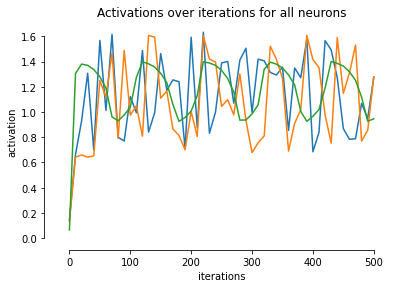

In [82]:
std = np.std(evaluations[:, 10:], axis=1)
j = np.where(std > 0.05)[0]

#i=np.arange(len(t_evaluations))
plt.plot(t_evaluations[j].T, evaluations[j].T)
sns.despine(trim=True, offset=10)
plt.xlabel("iterations")
plt.ylabel("activation")
plt.title("Activations over iterations for all neurons");
#plt.savefig('jitter.png')

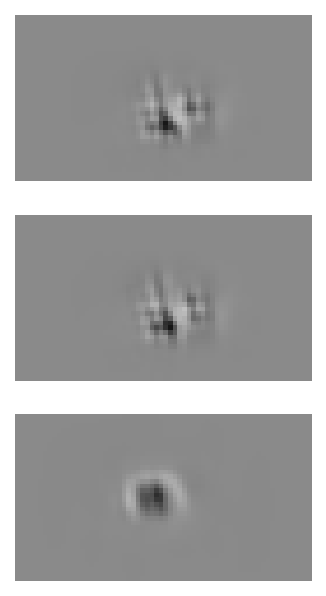

In [86]:
fig, axes = plt.subplots(3, 1, figsize=(5, 5), dpi=150)
for i, ax in zip(j, axes.flatten()):
    ax.imshow(MEIs[i], cmap="gray", vmin=MEIs.min(), vmax=MEIs.max() ) # vmin=MEIs.min(), vmax=MEIs.max() 
    ax.axis("off")
    #ax.text(0.5, 2.5, str(unit_IDs[i]), va='center', fontsize=8.5, color='k')
#fig.savefig('mei_jitter.png')

# Plot Activations

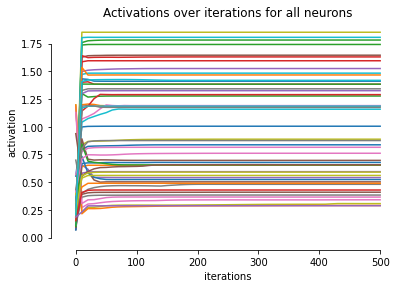

In [92]:
#i=np.arange(len(t_evaluations))
plt.plot(t_evaluations.T, evaluations.T)
sns.despine(trim=True, offset=10)
plt.xlabel("iterations")
plt.ylabel("activation")
plt.title("Activations over iterations for all neurons");
#plt.savefig('jitter.png')

In [96]:
(8115 + 8199 + 7916 + 8182 + 7700 + 8044 + 7344 + 7334 + 6848 + 6559 + 8107) - (3 * 4000)

72348

# plot MEIs

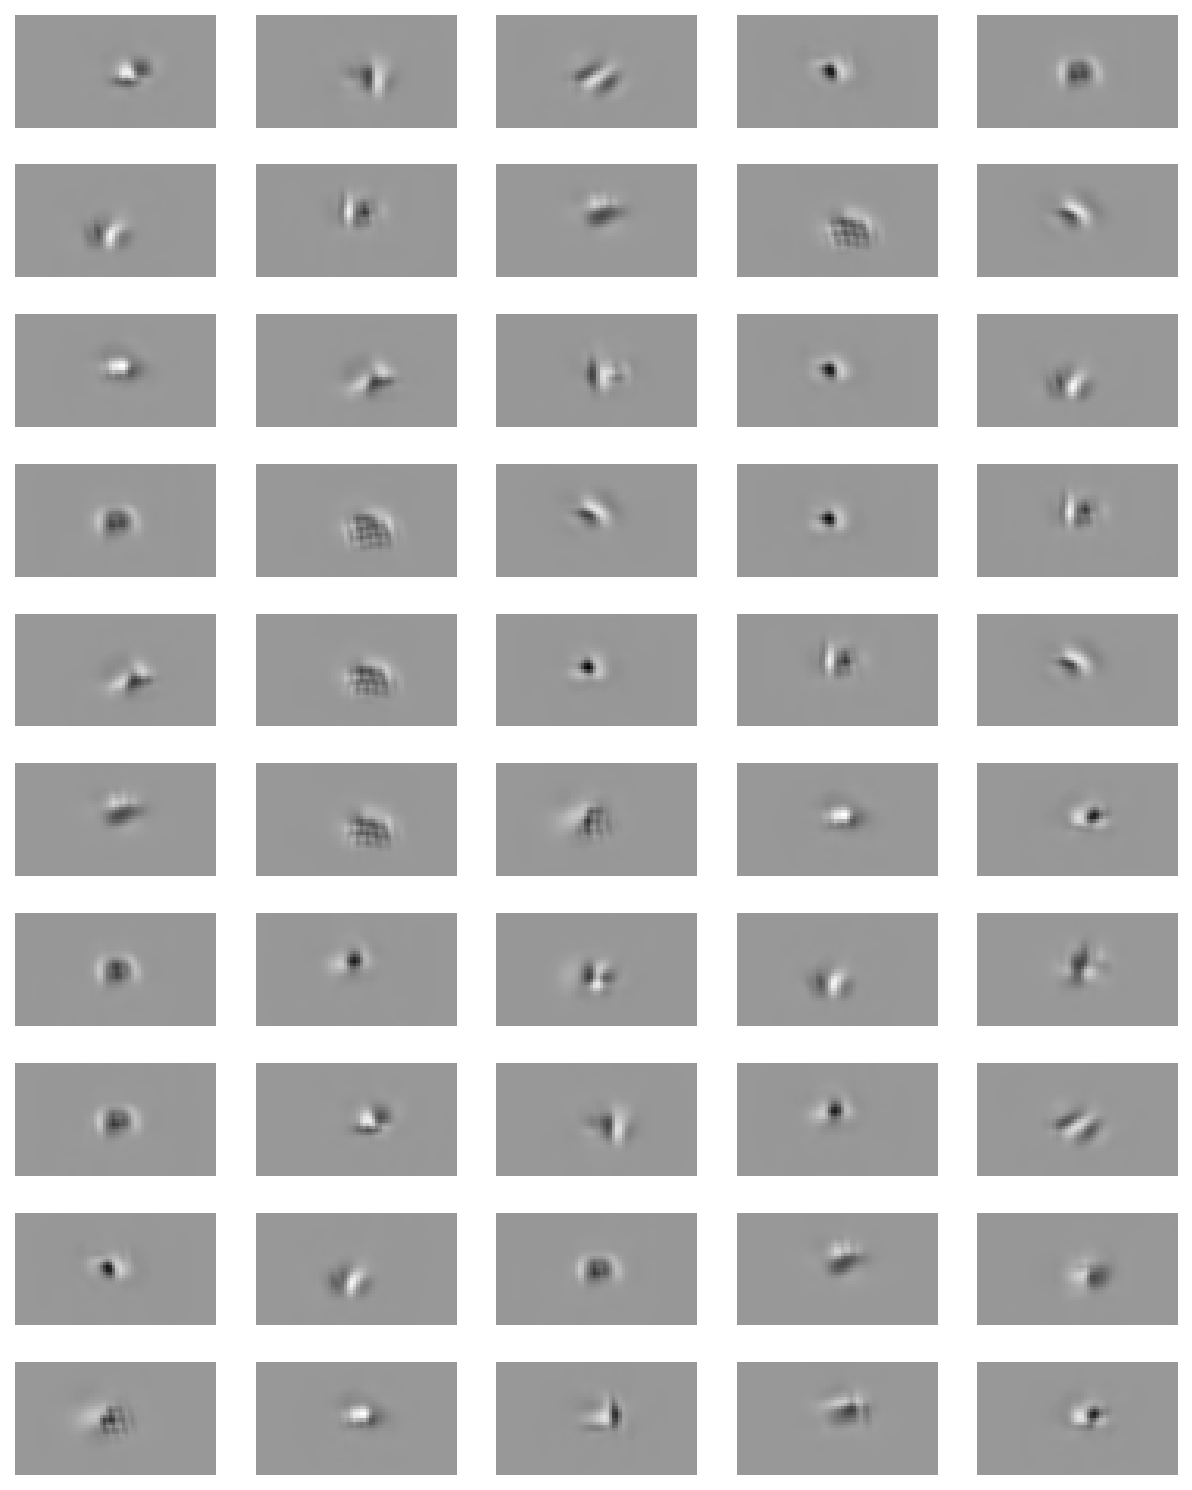

In [95]:
fig, axes = plt.subplots(10, 5, figsize=(10, 13), dpi=150)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(MEIs[i], cmap="gray", vmin=MEIs.min(), vmax=MEIs.max() ) # vmin=MEIs.min(), vmax=MEIs.max() 
    ax.axis("off")
    #ax.text(0.5, 2.5, str(unit_IDs[i]), va='center', fontsize=8.5, color='k')
#fig.savefig('mei.pdf')

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5), dpi=150)
ax[0].hist(MEIs.flatten(), bins=20)
ax[0].set_xlabel('pixel value')
ax[0].set_title('Pixel distribution all MEIs')

ax[1].hist(MEIs.max(axis=1).max(axis=1), bins=20)
ax[1].set_xlabel('pixel value')
ax[1].set_title('Max pixel value per MEI')

ax[2].hist(MEIs.min(axis=1).min(axis=1), bins=20)
ax[2].set_xlabel('pixel value')
ax[2].set_title('Min pixel value per MEI')

sns.despine(trim=True)
#fig.savefig('MEI pixel distribution')

In [ ]:
MEI() & 